In [32]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
from scipy.integrate import quad
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit
import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis

import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl'
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [18]:
ind_profile = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [19]:
ind_profile['radius_true'][0]

array([0.55273137, 0.67851916, 0.80686404, 1.01820147, 1.23706615,
       1.50303785, 1.81363909, 2.24654963, 2.7709657 , 3.37497761,
       4.10982024, 5.01707625, 6.11385028, 7.48693463, 9.10977681])

In [20]:
r_corner = np.logspace(np.log10(.5), np.log10(10), 16)

In [21]:
sum_weights_per_cluster_10 = []
sum_weights_per_cluster_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 10)
    sum_weights_per_cluster_10.append(np.sum(ind_profile['W_l_true'][i][mask]))
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 5.5)
    sum_weights_per_cluster_5.append(np.sum(ind_profile['W_l_true'][i][mask]))

In [22]:
ind_profile['weight_per_cluster_5'] = np.array(sum_weights_per_cluster_5)*1e27
ind_profile['weight_per_cluster_10'] = np.array(sum_weights_per_cluster_10)*1e27

In [23]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

In [24]:
z_max = max(Z_bin[-1])
z_min = min(Z_bin[0])
obs_min = min(Obs_bin[0])
obs_max = max(Obs_bin[-1])

In [25]:
z_min

0.2

# WL masses

## WL shear profiles

In [26]:
profile_sky_stack = prf.stacked_profile(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = ['weight_per_cluster_10','weight_per_cluster_5', 'richness', 'redshift'])

covariance_boot = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [27]:
covariance_sample = prf.sample_covariance(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    #n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [28]:
covariance_jackk = prf.jacknife_covariance(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                                            ra='ra', dec='dec',n_jack=500,
                    #n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [29]:
index = 4

In [33]:
def av_sigma_2(zl, cosmo=None):
    def sigma_c_2(zs):
        return cosmo.eval_sigma_crit(zl, zs)**2.
    def Chang(z): #Chang distribution of source redshift
        a = 1.24
        b = 1.01
        z_0 = 0.51
        return np.exp(-(z/z_0)**b)*z**a
    norm = quad(Chang,0,np.inf)[0]
    def __INTEGRAND__(z): return Chang(z)*sigma_c_2(z)
    return quad(__INTEGRAND__,zl + 0.1,100)[0]/norm
    
def shape_noise_ds(profile = 1,z_name = 'z_mean',r_corner=None, shapenoise=.1, ns_arcmin2=None, cosmo=None):
    
    #def ns_arcmin2(z):
    #    dy = 35-10
    #    dx=0.9-0.3
    #    return (z-0.3) * dy/dx + 35
    res=[]
    for p in profile:
        dS_arcmin2 = 3437.75**2*np.pi*np.array([r_corner[i+1]**2 - r_corner[i]**2 for i in range(len(r_corner)-1)])/(cosmo.eval_da(p[z_name])**2)
        Ngal = dS_arcmin2*ns_arcmin2#ns_arcmin2(p['z_mean'])*dS_arcmin2
        av_s_2 = av_sigma_2(p[z_name], cosmo=cosmo)
        res.append(av_s_2*shapenoise**2/(Ngal*p['n_stack']))
    return np.array(res)

In [34]:
shape_noise_ds(profile = ind_profile,z_name = 'redshift',r_corner=r_corner, shapenoise=.1, ns_arcmin2=30, cosmo=cosmo)

AttributeError: 'NumCosmoCosmology' object has no attribute 'smd'

[]

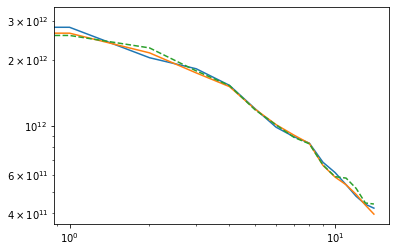

In [36]:
plt.plot(covariance_boot[index]['cov_t'].diagonal()**.5)
plt.plot(covariance_sample[index]['cov_t'].diagonal()**.5)
plt.plot(covariance_jackk[index]['cov_t'].diagonal()**.5, '--')
plt.loglog()